In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import cv2
import numpy as np


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import glob
import sklearn.metrics
import seaborn as sns
from keras.models import load_model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
random.seed(77)

In [ ]:
!cd "/content/drive/MyDrive/oct"
!unzip -qq "/content/drive/MyDrive/oct/OCT_small.zip"

replace OCT_small/test/CNV/CNV-6554931-1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
total_dir = "/content/OCT_small"
train_dir = "/content/OCT_small/train"
test_dir = "/content/OCT_small/test"

In [ ]:
classes = os.listdir(train_dir)
print(classes)

['DME', 'NORMAL', 'CNV', 'DRUSEN']


In [ ]:
dataset = {
    "img_path" : [], 
    "class" : [], 
    "split" : []
}

for split in os.listdir(total_dir):
  for where in os.listdir(total_dir + "/" + split):
    for image in glob.glob(total_dir+"/"+split+"/"+where+"/*.jpeg"):
      dataset["img_path"].append(image)
      dataset["class"].append(where)
      dataset["split"].append(split)

dataset = pd.DataFrame(dataset)
dataset.head()

,img_path,class,split
0,/content/OCT_small/test/DME/DME-9931747-3.jpeg,DME,test
1,/content/OCT_small/test/DME/DME-3358004-19.jpeg,DME,test
2,/content/OCT_small/test/DME/DME-3606968-15.jpeg,DME,test
3,/content/OCT_small/test/DME/DME-7757895-2.jpeg,DME,test
4,/content/OCT_small/test/DME/DME-7949765-2.jpeg,DME,test


In [ ]:
train_df = dataset[dataset["split"] == "train"]
test_df = dataset[dataset["split"] == "test"]
valid_df = dataset[dataset["split"] == "validation"]

print(test_df.head(10))

                                          img_path class split
0   /content/OCT_small/test/DME/DME-9931747-3.jpeg   DME  test
1  /content/OCT_small/test/DME/DME-3358004-19.jpeg   DME  test
2  /content/OCT_small/test/DME/DME-3606968-15.jpeg   DME  test
3   /content/OCT_small/test/DME/DME-7757895-2.jpeg   DME  test
4   /content/OCT_small/test/DME/DME-7949765-2.jpeg   DME  test
5  /content/OCT_small/test/DME/DME-8699233-19.jpeg   DME  test
6   /content/OCT_small/test/DME/DME-3546221-1.jpeg   DME  test
7   /content/OCT_small/test/DME/DME-8123126-5.jpeg   DME  test
8   /content/OCT_small/test/DME/DME-3347866-4.jpeg   DME  test
9   /content/OCT_small/test/DME/DME-1805818-5.jpeg   DME  test


In [ ]:
len(train_df), len(test_df), len(valid_df)

(4995, 1425, 709)

In [ ]:
# normal case의 imbalance 를 해결하기 위해
# 다른 class와 비슷한 수로 맞춤 (랜덤 샘플링으로 케이스를 1/8로 줄임)
def makedf(df) : 
  samples = df[df["class"] == "NORMAL"].sample(frac=0.125, random_state=77)
  others = df[df["class"] != "NORMAL"]
  result = pd.concat([samples, others], axis=0)
  return result

In [ ]:
train_df = makedf(train_df)
test_df = makedf(test_df)
valid_df = makedf(valid_df)  

Text(0.5, 1.0, 'Validation Dataset')

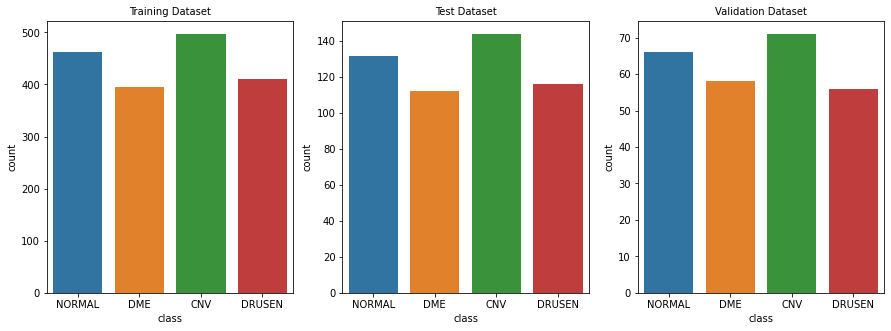

In [ ]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=train_df["class"])
plt.title("Training Dataset", size=10)

plt.subplot(1, 3, 2)
sns.countplot(x=test_df["class"])
plt.title("Test Dataset", size=10)

plt.subplot(1, 3, 3)
sns.countplot(x=valid_df["class"])
plt.title("Validation Dataset", size=10)

In [ ]:
X_train = train_df["img_path"]
y_train = train_df["class"]

X_test = test_df["img_path"]
y_test = test_df["class"]

X_val = valid_df["img_path"]
y_val = valid_df["class"]


In [ ]:
#케이스 확인
for name in list(train_df["class"].unique()):
  print(name, len(train_df[train_df["class"] == name]))


NORMAL 462
DME 396
CNV 497
DRUSEN 410


In [ ]:
#케이스 확인
for name in list(test_df["class"].unique()):
  print(name, len(test_df[test_df["class"] == name]))


NORMAL 132
DME 112
CNV 144
DRUSEN 116


In [ ]:
#케이스 확인
for name in list(valid_df["class"].unique()):
  print(name, len(valid_df[valid_df["class"] == name]))


NORMAL 66
DME 58
CNV 71
DRUSEN 56


In [ ]:
#중앙화
def norm_digit(img):
    m = cv2.moments(img)
    cx = m['m10'] / m['m00']
    cy = m['m01'] / m['m00']
    h, w = img.shape[:2]
    aff = np.array([[1, 0, w/2 - cx], [0, 1, h/2 - cy]], dtype=np.float32)
    dst = cv2.warpAffine(img, aff, (0, 0))
    return dst

In [ ]:
from tqdm.notebook import tqdm
from skimage.color import rgb2gray
from skimage.transform import resize

def img_preprocess(imgs):
  images = []
  bar_total = tqdm(imgs)
  for file in bar_total:
          
          img = cv2.imread(file, 0)
          img = np.where(img == 255, 0, img)
          img = norm_digit(img)
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
          #cl1 = cv2.fastNlMeansDenoising(img, None, 12, 7,21)
          cl1 = clahe.apply(img)
          
        
          images.append(resize(cl1, (224,224,3)))
          #images.append(resize(img, (224,224,3)))
  images = np.array(images)
  return images

In [ ]:
X_train = img_preprocess(X_train)
X_test = img_preprocess(X_test)
X_val = img_preprocess(X_val)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def makelabel(labels):
  encoder = LabelEncoder()
  encoder.fit(labels)
  labels_encoded = encoder.transform(labels)
  labels_encoded[:3], encoder.classes_
  return labels_encoded

In [ ]:
y_train = makelabel(y_train)
y_test = makelabel(y_test)
y_val = makelabel(y_val)

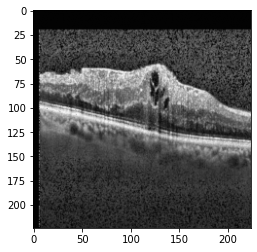

In [ ]:

plt.imshow(X_train[random.choice(range(len(X_train)))])

In [ ]:
#train set용 image data generator
#여기서 증강 방식을 결정 
datagen = ImageDataGenerator(

    rotation_range=10,
    horizontal_flip=True,
    fill_mode = "nearest"
)

In [ ]:
#test set는 증강을 진행하지 않음
#단 data generatore를 거쳐야하기 때문에 test data용 generator를 생성함 
test_datagen = ImageDataGenerator()
    

In [ ]:

train_augment = datagen.flow(
    x=X_train, y=y_train, batch_size=5, 
    shuffle=True, sample_weight=None, seed=13,
    save_to_dir=None)

test_augment = test_datagen.flow(
    x=X_test, y=y_test, batch_size=1, 
    shuffle=True, sample_weight=None, seed=13,
    save_to_dir=None)


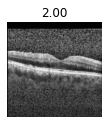

In [ ]:
#데이터 뽑아보기 

augs = test_augment.__getitem__(8)

plt.figure(figsize=(16, 8))
for i, img in enumerate(augs[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f' % augs[1][i])
    plt.axis('off')
    plt.imshow(img.squeeze())

In [ ]:
base = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), weights=None, pooling="max")
input = tf.keras.layers.Input(shape=(224, 224, 3))
base = base(input)
out = tf.keras.layers.Dense(4, activation="softmax")(base)
model = tf.keras.models.Model(input, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=1, mode='min', baseline=None, restore_best_weights=False)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=losses.sparse_categorical_crossentropy, 
              metrics=['accuracy']
              )
#lr 줄이기 배치 늘리기 early stop 빼기

In [ ]:
history = model.fit(train_augment, 
                    validation_data = test_augment, batch_size=64, 
                    steps_per_epoch = len(X_train)/16, epochs=1000, 
                    )

Epoch 1/1000
110/110 [==============================] - 36s 129ms/step - loss: 7.9281 - accuracy: 0.3027 - val_loss: 1.6872 - val_accuracy: 0.2619
Epoch 2/1000
110/110 [==============================] - 13s 120ms/step - loss: 4.4466 - accuracy: 0.3063 - val_loss: 1.5794 - val_accuracy: 0.2857
Epoch 3/1000
110/110 [==============================] - 13s 119ms/step - loss: 3.4115 - accuracy: 0.2973 - val_loss: 2.3199 - val_accuracy: 0.2302
Epoch 4/1000
110/110 [==============================] - 13s 120ms/step - loss: 3.4503 - accuracy: 0.2955 - val_loss: 38.8590 - val_accuracy: 0.2897
Epoch 5/1000
110/110 [==============================] - 13s 118ms/step - loss: 2.7143 - accuracy: 0.3009 - val_loss: 107.8633 - val_accuracy: 0.3234
Epoch 6/1000
110/110 [==============================] - 13s 119ms/step - loss: 2.7691 - accuracy: 0.3045 - val_loss: 1.5703 - val_accuracy: 0.2619
Epoch 7/1000
110/110 [==============================] - 13s 120ms/step - loss: 2.9210 - accuracy: 0.2739 - val_loss

KeyboardInterrupt: ignored

NameError: ignored

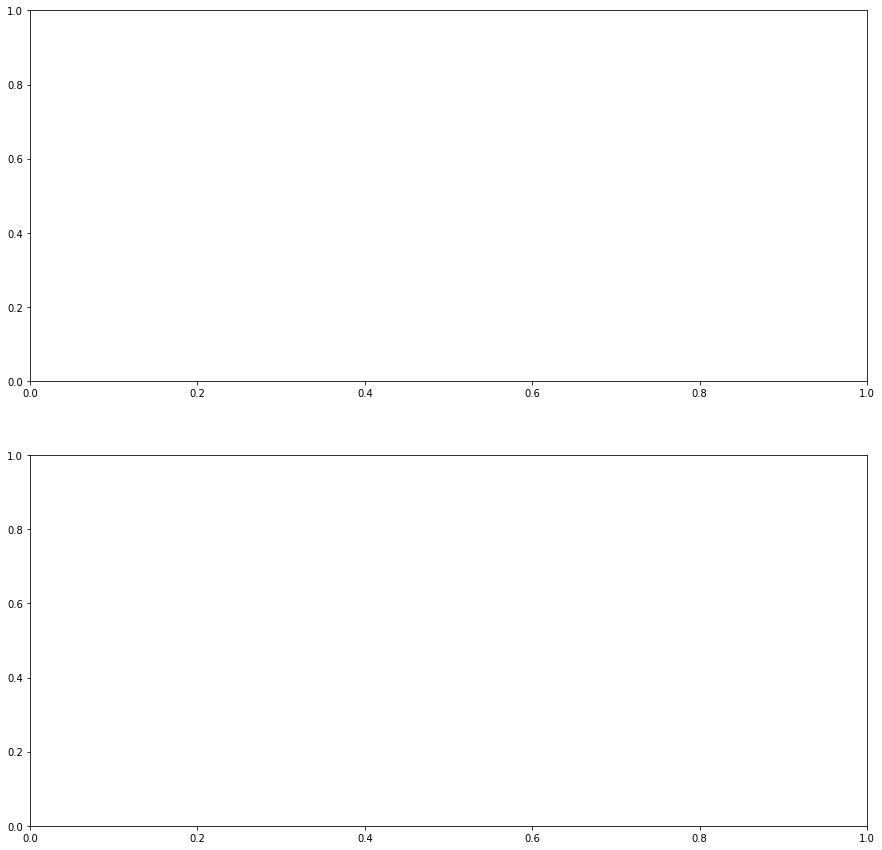

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 2s 69ms/step - loss: 0.7973 - accuracy: 0.8611


[0.7973029613494873, 0.8611111044883728]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

pred = model.predict(X_val)
pred = np.argmax(pred, axis=1)
confusion_matrix(y_val, pred)

array([[63,  1,  6,  1],
       [ 3, 53,  1,  1],
       [ 1,  1, 46,  8],
       [ 0,  2,  0, 64]])

In [ ]:
accuracy_score(y_val, pred)

0.900398406374502